torch.Size([1000, 1, 28, 28])


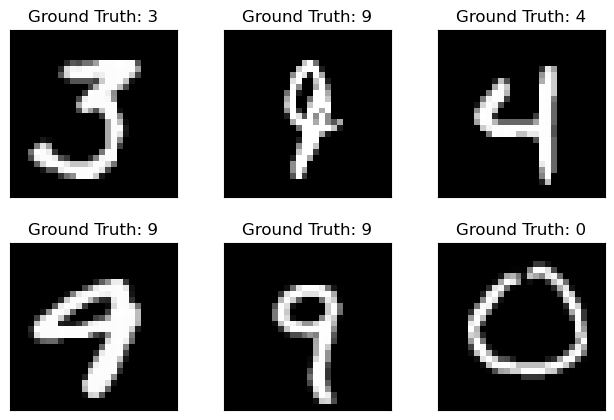


Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056642
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010620
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.008978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.867195
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.755030
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.617570
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411560
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.595001
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.259282
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.326851
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.236279
Train Epoch: 1 [12160/6

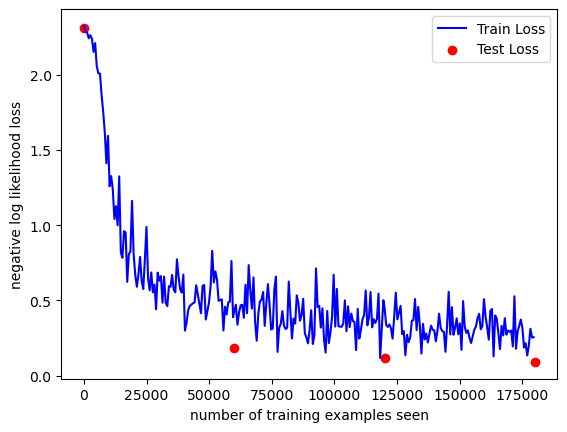

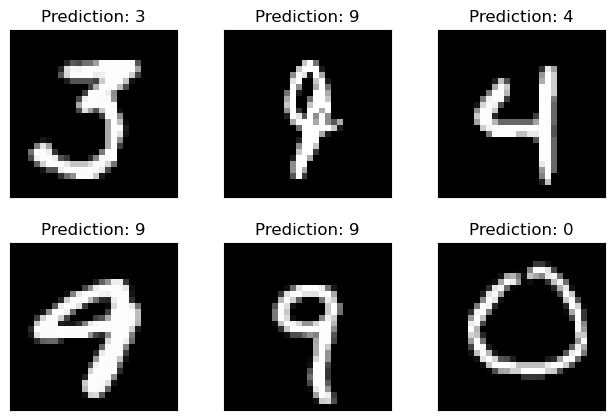

In [2]:
# Import necessary libraries for neural network construction, dataset handling, and plotting
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Set training parameters
n_epochs = 3  # Number of epochs to train the model
batch_size_train = 64  # Batch size for training
batch_size_test = 1000  # Batch size for testing
learning_rate = 0.01  # Learning rate for the optimizer
momentum = 0.5  # Momentum for the optimizer
log_interval = 10  # How often to log training progress

# Ensure reproducibility
random_seed = 1  # Seed for random number generators
torch.backends.cudnn.enabled = False  # Ensures consistent behavior
torch.manual_seed(random_seed)  # Seed the random number generator in torch

# Load and normalize MNIST training data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./mnist_data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train, shuffle=True)

# Load and normalize MNIST testing data
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./mnist_data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test, shuffle=True)

# Fetch one batch of test data to visualize
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Print shape of the example test data batch
print(example_data.shape)

# Visualize some test images and their ground truth labels
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()  # Fixed show function

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # First convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)  # Second convolutional layer
        self.conv2_drop = nn.Dropout2d()  # Dropout layer after second convolution
        self.fc1 = nn.Linear(320, 50)  # First fully connected layer
        self.fc2 = nn.Linear(50, 10)  # Second fully connected layer (output layer)

    def forward(self, x):
        # Define forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Fixed missing dim=1

# Initialize the network and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# Initialize lists to track losses
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# Define training function
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))

# Define testing function
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Fixed deprecated 'size_average'
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()  # Fixed missing .item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

# Perform an initial test, then train and test over all epochs
test()  # Initial test to establish baseline
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

# Plot training and testing losses over time
plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()  # Fixed show function

# Generate predictions for example test data
with torch.no_grad():
    output = network(example_data)

# Visualize predictions for some test images
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()  